# Projet 3A - Classifieurs
### Bilel Ouahmed, Léo Caulier, Mathieu Delattre

## Imports et initialisation

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import re
from os import listdir
from os.path import isfile, join
from numpy import asarray
import pandas as pd
import random
import os

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [6]:
# With Google Colab
from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v

cwd = os.getcwd()

monchemin = 'drive/My Drive/Centrale Marseille/3A/Projet 3A/dataset'

dir_path=os.path.join(cwd, monchemin)
dirs =os.listdir(dir_path)
print(dir_path)
print (dirs)

os.chdir(dir_path)

!export PYTHONPATH=$PYTHONPATH:dir_path

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# On local computer
dir_path = "D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur"
os.chdir(dir_path)

## Image preprocessing

### Front

In [9]:
foldername_front = os.listdir('images_front')
front_arrays = []

for filename in foldername_front:
  front_arrays.append(img_to_array(load_img(dir_path + '/images_front/' + filename, target_size=(224, 224))))

### Nutrition

In [10]:
foldername_nutrition = os.listdir('images_nutrition')
nutrition_arrays = []

for filename in foldername_nutrition:
  nutrition_arrays.append(img_to_array(load_img(dir_path + '/images_nutrition/' + filename, target_size=(224, 224))))

### Ingredients

In [11]:
foldername_ingredients = os.listdir('images_ingredients')
ingredients_arrays = []

for filename in foldername_ingredients:
    ingredients_arrays.append(img_to_array(load_img(dir_path + '/images_ingredients/' + filename, target_size=(224, 224))))

### Fusion

In [12]:
X = np.concatenate((front_arrays, ingredients_arrays, nutrition_arrays))
y = np.concatenate((np.array([[1, 0, 0]]*len(front_arrays)), np.array([[0, 1, 0]]*len(ingredients_arrays)), np.array([[0, 0, 1]]*len(front_arrays))))
p = np.random.permutation(len(y))

X = X[p]
y = y[p]

In [13]:
# Saving the data to save RAM
with open('array_entree_224.npy', 'wb') as f:
    np.save(f, X)

with open('array_sortie_224.npy', 'wb') as f:
    np.save(f, y)

## One vs Rest : Front

In [3]:
with open('array_entree_224.npy', 'rb') as f:
    X = np.load(f)

with open('array_sortie_224.npy', 'rb') as f:
    y = np.load(f)
    
train_proportion = int(0.8*len(X))

X_train = X[:train_proportion]
X_test = X[train_proportion:]
y_train = y[:train_proportion]
y_test = y[train_proportion:]

In [15]:
def plot_learning_curves(history):
    #print history.history.keys()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [20]:
classifier = Sequential()

classifier.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))
classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Conv2D(512, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))
classifier.add(Conv2D(512, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Flatten())
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=1, activation='sigmoid'))

classifier.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
checkpoint = ModelCheckpoint(dir_path + '/models/callback_checkpoint/model.final', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

h = classifier.fit(X_train, y_train[:, 0], batch_size=32, epochs=10, validation_split=0.1, callbacks=[checkpoint], verbose=1)

Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 1.5369 - accuracy: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.82789, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 858s 7s/step - loss: 1.5369 - accuracy: 0.6689 - val_loss: 0.4127 - val_accuracy: 0.8279
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8377
Epoch 2: val_accuracy improved from 0.82789 to 0.87146, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 827s 6s/step - loss: 0.4088 - accuracy: 0.8377 - val_loss: 0.3359 - val_accuracy: 0.8715
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8627
Epoch 3: val_accuracy improved from 0.87146 to 0.89107, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 814s 6s/step - loss: 0.3644 - accuracy: 0.8627 - val_loss: 0.3332 - val_accuracy: 0.8911
Epoch 4/10
129/129 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.8809
Epoch 4: val_accuracy did not improve from 0.89107
129/129 [==============================] - 814s 6s/step - loss: 0.3169 - accuracy: 0.8809 - val_loss: 0.2775 - val_accuracy: 0.8911
Epoch 5/10
129/129 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8947
Epoch 5: val_accuracy improved from 0.89107 to 0.90414, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 818s 6s/step - loss: 0.2753 - accuracy: 0.8947 - val_loss: 0.2464 - val_accuracy: 0.9041
Epoch 6/10
129/129 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9095
Epoch 6: val_accuracy improved from 0.90414 to 0.92375, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 807s 6s/step - loss: 0.2525 - accuracy: 0.9095 - val_loss: 0.2335 - val_accuracy: 0.9237
Epoch 7/10
129/129 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9171
Epoch 7: val_accuracy did not improve from 0.92375
129/129 [==============================] - 807s 6s/step - loss: 0.2206 - accuracy: 0.9171 - val_loss: 0.2320 - val_accuracy: 0.9063
Epoch 8/10
129/129 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9229
Epoch 8: val_accuracy did not improve from 0.92375
129/129 [==============================] - 806s 6s/step - loss: 0.2215 - accuracy: 0.9229 - val_loss: 0.1792 - val_accuracy: 0.9194
Epoch 9/10
129/129 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9265
Epoch 9: val_accuracy improved from 0.92375 to 0.93028, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 805s 6s/step - loss: 0.1914 - accuracy: 0.9265 - val_loss: 0.1511 - val_accuracy: 0.9303
Epoch 10/10
129/129 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9389
Epoch 10: val_accuracy improved from 0.93028 to 0.93682, saving model to D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/callback_checkpoint\model.final\assets


129/129 [==============================] - 816s 6s/step - loss: 0.1599 - accuracy: 0.9389 - val_loss: 0.1593 - val_accuracy: 0.9368


Score :  [0.10673404484987259, 0.9607329964637756]


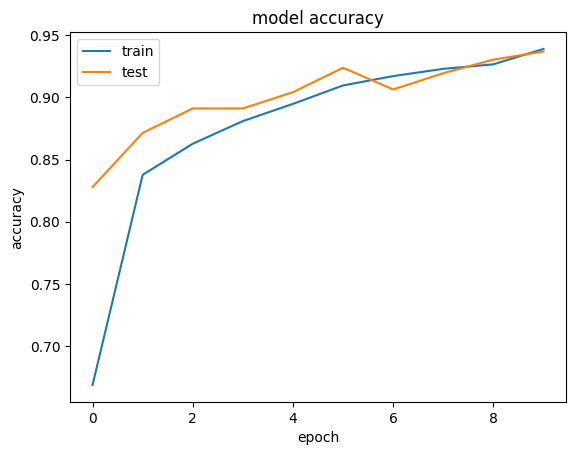

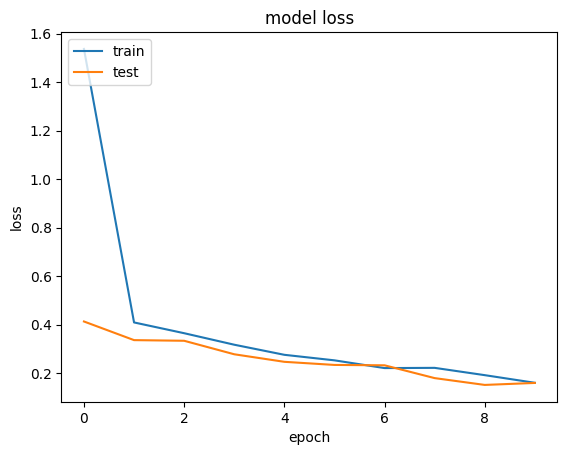

In [31]:
score = classifier.evaluate(X_test, y_test[:, 0], verbose=0)
print("Score : ", score)
plot_learning_curves(h)

In [23]:
classifier.save(dir_path + '/models/final_model_front')

INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/final_model_front\assets


INFO:tensorflow:Assets written to: D:/Users/leoca/Documents/Cours/Projet_3A/Dataset_couleur/models/final_model_front\assets


## Ingrédients vs Nutrition

In [24]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Cloning https://github.com/openai/CLIP.git to c:\users\leoca\appdata\local\temp\pip-req-build-gg343jmy
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\leoca\AppData\Local\Temp\pip-req-build-gg343jmy'

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
import clip

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50x16", device=device)

def ingredients_or_nutrition(img_to_process):

  img = preprocess(Image.fromarray((img_to_process).astype('uint8'))).unsqueeze(0).to(device)
  text = clip.tokenize(["ingredient", "nutritional value"]).to(device)

  with torch.no_grad():
      image_features = model.encode_image(img)
      text_features = model.encode_text(text)
      
      logits_per_image, logits_per_text = model(img, text)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()
  
  return np.argmax(probs) + 1

## Model Performances

In [6]:
classifier = load_model(dir_path + '/models/VGG16_224_32_10_01')

In [32]:
errors = 0

for i in range(len(X_test)):
  img_to_process = X_test[i]
  is_front = classifier.predict(X_test[i:i+1])
  if is_front < 0.5:
    class_predicted = np.eye(3)[ingredients_or_nutrition(img_to_process)]
  else:
    class_predicted = np.eye(3)[0]
  if (class_predicted == y_test[i]).all():
    pass
  else:
    errors += 1
    print("Erreur rencontrée (" + str(errors) + "/" + str(i) + ") ------- Classe prédite : " + str(class_predicted.astype(int)) + " / Vraie classe : " + str(y_test[i]))

1/1 [==============================] - 0s 63ms/step
Erreur rencontrée (1/9) ------- Classe prédite : [0 1 0] / Vraie classe : [0 0 1]
1/1 [==============================] - 0s 77ms/step
Erreur rencontrée (2/12) ------- Classe prédite : [0 0 1] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 82ms/step
Erreur rencontrée (3/17) ------- Classe prédite : [1 0 0] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 83ms/step
Erreur rencontrée (4/30) ------- Classe prédite : [1 0 0] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 81ms/step
Erreur rencontrée (5/39) ------- Classe prédite : [1 0 0] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 83ms/step
Erreur rencontrée (6/58) ------- Classe prédite : [0 0 1] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 85ms/step
Erreur rencontrée (7/59) ------- Classe prédite : [0 0 1] / Vraie classe : [0 1 0]
1/1 [==============================] - 0s 82ms/step
Erre

In [33]:
print('Accuracy : ' + str(100*(len(X_test)-errors)/len(X_test)))

Accuracy : 90.05235602094241
